In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from boruta import BorutaPy as boruta
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [148]:
data = pd.read_csv('../Details/dataset/SentimentbasedRecoEngine/sample30.csv', index_col=None)
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [149]:
print(data['manufacturer'].nunique())
print(data['name'].nunique())
print(data['categories'].nunique())
print(data['brand'].nunique())

227
271
270
214


In [150]:
df = data[(data['reviews_username'].isnull()==False) & (data['user_sentiment'].isnull()==False)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29936 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29936 non-null  object
 1   brand                 29936 non-null  object
 2   categories            29936 non-null  object
 3   manufacturer          29795 non-null  object
 4   name                  29936 non-null  object
 5   reviews_date          29896 non-null  object
 6   reviews_didPurchase   15931 non-null  object
 7   reviews_doRecommend   27395 non-null  object
 8   reviews_rating        29936 non-null  int64 
 9   reviews_text          29936 non-null  object
 10  reviews_title         29747 non-null  object
 11  reviews_userCity      1900 non-null   object
 12  reviews_userProvince  166 non-null    object
 13  reviews_username      29936 non-null  object
 14  user_sentiment        29936 non-null  object
dtypes: int64(1), object(14)
memory usage

In [151]:
df['user_sentiment'].value_counts()

Positive    26579
Negative     3357
Name: user_sentiment, dtype: int64

In [152]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [153]:
df.groupby(['user_sentiment', 'reviews_doRecommend'])['id'].count()

user_sentiment  reviews_doRecommend
Negative        False                    556
                True                    2380
Positive        False                    994
                True                   23465
Name: id, dtype: int64

In [154]:
df = df[['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_text', 'reviews_title', 'reviews_doRecommend',
         'reviews_rating', 'reviews_username', 'user_sentiment']]
df.shape

(29936, 12)

In [155]:
df.isnull().sum()

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             40
reviews_text              0
reviews_title           189
reviews_doRecommend    2541
reviews_rating            0
reviews_username          0
user_sentiment            0
dtype: int64

In [156]:
df['reviews_title'] = df['reviews_title'].astype('O')
cnt = [i for i in df['reviews_title'].to_list() if isinstance(i, float)]
print(cnt)
cnt = [i for i in df['reviews_text'].to_list() if i.isnumeric()]
print(cnt)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[]


In [157]:
df['reviews_title'] = df['reviews_title'].fillna('NF')
df = df.reset_index(drop=True)

In [158]:
for i in range(len(df)):
  if df.loc[i,'reviews_title'] == 'NF':
    if df.loc[i, 'user_sentiment'] == 'Positive':
      df.loc[i,'reviews_title']='Good'
    if df.loc[i, 'user_sentiment'] == 'Negative':
      df.loc[i,'reviews_title']='Bad'

df['manufacturer'].fillna(df['brand'], inplace=True)

In [159]:
stemmer = PorterStemmer()

# add stemming and lemmatisation in the preprocess function
def preprocess(document):
    'changes document to lower case and removes stopwords'
    document = document.lower()
    words = word_tokenize(document)
    words = [word for word in words if word not in stopwords.words("english")]
    words = [stemmer.stem(word) for word in words]
    document = " ".join(words)
    return document

In [160]:
df['reviews_text'] = df['reviews_title']+' '+df['reviews_text']
df['reviews_text'][0]

"Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

In [161]:
df['proc_reviews_text'] = df['reviews_text'].apply(preprocess)
df.shape

(29936, 13)

In [162]:
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_text,reviews_title,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,proc_reviews_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,Just Awesome i love this album. it's very good...,Just Awesome,NaN,5,joshua,Positive,awesom love album . 's good . hip hop side cur...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,Good Good flavor. This review was collected as...,Good,NaN,5,dorothy w,Positive,good good flavor . review collect part promot .


In [163]:
# df.to_csv('final_data.csv', index=None)

In [ ]:
df = pd.read_csv('../Details/dataset/SentimentbasedRecoEngine/final_data.csv', index_col=None)
df.info()

In [ ]:
df['user_sentiment'] = df['user_sentiment'].map({'Positive':1, 'Negative':0})
df['user_sentiment'].value_counts()

In [ ]:
df.loc[0, 'reviews_text']

In [ ]:
df.loc[0, 'proc_reviews_text']

In [ ]:
X, y = df['proc_reviews_text'], df['user_sentiment']
xtrain, xtest, ytrain, ytest = train_test_split(df['proc_reviews_text'], df['user_sentiment'], test_size=0.25)

## Feature Creation
1. TF-IDF Vectorizer 
2. Bag-of-Words 

In [37]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_model = tfidf_vectorizer.fit(X)

In [38]:
xtrain_tfi = tfidf_model.transform(xtrain)
xtest_tfi  = tfidf_model.transform(xtest)

xdf_tf = pd.DataFrame(xtrain_tfi.toarray(), columns=tfidf_vectorizer.get_feature_names())
print(xdf_tf.shape)

(22452, 13290)


In [39]:
bow_vectorizer = CountVectorizer(stop_words='english')
bow_model = bow_vectorizer.fit(X)

In [40]:
xtrain_bow = bow_model.transform(xtrain)
xtest_bow  = bow_model.transform(xtest)

xdf_bow = pd.DataFrame(xtrain_bow.toarray(), columns=bow_vectorizer.get_feature_names())
print(xdf_bow.shape)

(22452, 13076)


In [41]:
xtrain_tfi.shape, xtest_tfi.shape, xtrain_bow.shape, xtest_bow.shape

((22452, 13290), (7484, 13290), (22452, 13076), (7484, 13076))

## Class Imbalance Fix
1. TF-IDF features
2. Bag-of-Words features

In [42]:
oversample = SMOTE()
x_train_tf, y_train_tf = oversample.fit_resample(xtrain_tfi, ytrain)

In [43]:
y_train_tf.value_counts(), x_train_tf.shape

(0    19931
 1    19931
 Name: user_sentiment, dtype: int64,
 (39862, 13290))

In [44]:
oversample = SMOTE()
x_train_bw, y_train_bw = oversample.fit_resample(xtrain_bow, ytrain)

In [45]:
y_train_bw.value_counts(), x_train_bw.shape

(0    19931
 1    19931
 Name: user_sentiment, dtype: int64,
 (39862, 13076))

## Modelling
1. TF-IDF
2. Bag-of-Words

### Logistic Regression Model

In [49]:
logreg1 = LogisticRegression(penalty="l2", random_state=42, C=3.5)
logreg1.fit(x_train_tf, y_train_tf)

pred_train = logreg1.predict(x_train_tf)
pred_test  = logreg1.predict(xtest_tfi)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
print("Train Report: {}".format(classification_report(pred_train, y_train_tf)))
print("Test accuracy: {}".format(classification_report(pred_test, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.97      0.92      0.94     20838
           1       0.92      0.96      0.94     19024

    accuracy                           0.94     39862
   macro avg       0.94      0.94      0.94     39862
weighted avg       0.94      0.94      0.94     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.75      0.45      0.56      1396
           1       0.88      0.97      0.92      6088

    accuracy                           0.87      7484
   macro avg       0.82      0.71      0.74      7484
weighted avg       0.86      0.87      0.86      7484



In [51]:
print(accuracy_score(pred_test, ytest), roc_auc_score(pred_test, ytest))

0.8701229289150187 0.7087261708881014


Old: Train accuracy: 0.8899546647578144 . Test accuracy: 0.8838659392049883
Train AUC: 0.9449458052810008. Test AUC: 0.5255060352831941

In [52]:
logreg2 = LogisticRegression(penalty="l2", random_state=42, C=3.5)
logreg2.fit(x_train_bw, y_train_bw)

pred_train2 = logreg2.predict(x_train_bw)
pred_test2  = logreg2.predict(xtest_bow)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [53]:
print("Train Report: {}".format(classification_report(pred_train2, y_train_bw)))
print("Test accuracy: {}".format(classification_report(pred_test2, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.97      0.96      0.97     20036
           1       0.96      0.97      0.97     19826

    accuracy                           0.97     39862
   macro avg       0.97      0.97      0.97     39862
weighted avg       0.97      0.97      0.97     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.66      0.51      0.58      1076
           1       0.92      0.96      0.94      6408

    accuracy                           0.89      7484
   macro avg       0.79      0.73      0.76      7484
weighted avg       0.88      0.89      0.89      7484



In [54]:
print(accuracy_score(pred_test2, ytest), roc_auc_score(pred_test2, ytest))

0.892036344200962 0.7343457759584905


### Naive Bayes Model

In [85]:
bnb1 = BernoulliNB()
bnb1.fit(x_train_tf, y_train_tf)

pred_train_nb1 = bnb1.predict(x_train_tf)
pred_test_nb1  = bnb1.predict(xtest_tfi)

In [86]:
print("Train Report: {}".format(classification_report(pred_train_nb1, y_train_tf)))
print("Test accuracy: {}".format(classification_report(pred_test_nb1, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.67      0.88      0.76     15055
           1       0.91      0.73      0.81     24807

    accuracy                           0.79     39862
   macro avg       0.79      0.81      0.79     39862
weighted avg       0.82      0.79      0.79     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.32      0.29      0.30       935
           1       0.90      0.91      0.91      6549

    accuracy                           0.84      7484
   macro avg       0.61      0.60      0.61      7484
weighted avg       0.83      0.84      0.83      7484



In [87]:
print(accuracy_score(pred_test_nb1, ytest), roc_auc_score(pred_test_nb1, ytest))

0.835515766969535 0.6011723225083145


In [88]:
bnb2 = BernoulliNB()
bnb2.fit(x_train_bw, y_train_bw)

pred_train_nb2 = bnb2.predict(x_train_bw)
pred_test_nb2  = bnb2.predict(xtest_bow)

In [89]:
print("Train Report: {}".format(classification_report(pred_train_nb2, y_train_bw)))
print("Test accuracy: {}".format(classification_report(pred_test_nb2, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.92      0.81      0.86     22807
           1       0.78      0.91      0.84     17055

    accuracy                           0.85     39862
   macro avg       0.85      0.86      0.85     39862
weighted avg       0.86      0.85      0.85     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.49      0.20      0.29      2029
           1       0.76      0.92      0.83      5455

    accuracy                           0.73      7484
   macro avg       0.62      0.56      0.56      7484
weighted avg       0.69      0.73      0.68      7484



In [90]:
print(accuracy_score(pred_test_nb2, ytest), roc_auc_score(pred_test_nb2, ytest))

0.7272848743987173 0.5626644181820071


### XGBoost Classifier

In [91]:
xgb1 = XGBClassifier()
xgb1.fit(x_train_tf, y_train_tf)

pred_train_xg1 = xgb1.predict(x_train_tf)
pred_test_xg1  = xgb1.predict(xtest_tfi)

D:\Programs\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
print("Train Report: {}".format(classification_report(pred_train_xg1, y_train_tf)))
print("Test accuracy: {}".format(classification_report(pred_test_xg1, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.95      0.95      0.95     19817
           1       0.95      0.95      0.95     20045

    accuracy                           0.95     39862
   macro avg       0.95      0.95      0.95     39862
weighted avg       0.95      0.95      0.95     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.61      0.50      0.55      1018
           1       0.92      0.95      0.94      6466

    accuracy                           0.89      7484
   macro avg       0.76      0.72      0.74      7484
weighted avg       0.88      0.89      0.88      7484



In [93]:
print(accuracy_score(pred_test_xg1, ytest), roc_auc_score(pred_test_xg1, ytest))

0.8874933190807055 0.7230084279443874


In [94]:
xgb2 = XGBClassifier()
xgb2.fit(x_train_bw, y_train_bw)

pred_train_xg2 = xgb2.predict(x_train_bw)
pred_test_xg2  = xgb2.predict(xtest_bow)

D:\Programs\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
print("Train Report: {}".format(classification_report(pred_train_xg2, y_train_bw)))
print("Test accuracy: {}".format(classification_report(pred_test_xg2, ytest)))

Train Report:               precision    recall  f1-score   support

           0       0.93      0.98      0.95     19063
           1       0.98      0.94      0.96     20799

    accuracy                           0.96     39862
   macro avg       0.96      0.96      0.96     39862
weighted avg       0.96      0.96      0.96     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.45      0.66      0.54       575
           1       0.97      0.93      0.95      6909

    accuracy                           0.91      7484
   macro avg       0.71      0.80      0.74      7484
weighted avg       0.93      0.91      0.92      7484



In [96]:
print(accuracy_score(pred_test_xg2, ytest), roc_auc_score(pred_test_xg2, ytest))

0.9127471940138963 0.7964924138017835


### Random Forest Model

In [97]:
rf1 = RandomForestClassifier()
rf1.fit(x_train_tf, y_train_tf)

pred_train_rf1 = rf1.predict(x_train_tf)
pred_test_rf1  = rf1.predict(xtest_tfi)

In [98]:
print("Train Report: {}".format(classification_report(pred_train_rf1, y_train_tf)))
print("Test accuracy: {}".format(classification_report(pred_test_rf1, ytest)))

Train Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19933
           1       1.00      1.00      1.00     19929

    accuracy                           1.00     39862
   macro avg       1.00      1.00      1.00     39862
weighted avg       1.00      1.00      1.00     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.39      0.56      0.46       576
           1       0.96      0.93      0.94      6908

    accuracy                           0.90      7484
   macro avg       0.68      0.75      0.70      7484
weighted avg       0.92      0.90      0.91      7484



In [99]:
print(accuracy_score(pred_test_rf1, ytest), roc_auc_score(pred_test_rf1, ytest))

0.8981827899518974 0.74513195248665


In [100]:
rf2 = RandomForestClassifier()
rf2.fit(x_train_bw, y_train_bw)

pred_train_rf2 = rf2.predict(x_train_bw)
pred_test_rf2  = rf2.predict(xtest_bow)

In [101]:
print("Train Report: {}".format(classification_report(pred_train_rf2, y_train_tf)))
print("Test accuracy: {}".format(classification_report(pred_test_rf2, ytest)))

Train Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19941
           1       1.00      1.00      1.00     19921

    accuracy                           1.00     39862
   macro avg       1.00      1.00      1.00     39862
weighted avg       1.00      1.00      1.00     39862

Test accuracy:               precision    recall  f1-score   support

           0       0.54      0.54      0.54       829
           1       0.94      0.94      0.94      6655

    accuracy                           0.90      7484
   macro avg       0.74      0.74      0.74      7484
weighted avg       0.90      0.90      0.90      7484



In [102]:
print(accuracy_score(pred_test_rf2, ytest), roc_auc_score(pred_test_rf2, ytest))

0.8972474612506681 0.7410540520700127


In [103]:
rf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Model Selection
1. XGBoost with bag of words feature extraction performs best among all 4 models
2. The model's performance can be improved using feature selection/dimensionality reduction on the data and hyperparameter optimization of the model

#### Saving XGBoost Model and Bag-of-words model

In [104]:
import pickle

In [108]:
# pkl_filename = "tfidf_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(tfidf_model, file)
    
# pkl_filename = "bow_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(bow_model, file)

In [106]:
# pkl_filename = "xgb_tf_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(xgb1, file)

# pkl_filename = "xgb_bow_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(xgb2, file)

## Prediction Pipeline

In [144]:
def process_review_pipeline(reviews_list):
    pass

In [109]:
tf_model_file = "tfidf_model.pkl"
with open(tf_model_file, 'rb') as file:
    tf_model = pickle.load(file)
    
xgtf_model_file = "xgb_tf_model.pkl"
with open(xgtf_model_file, 'rb') as file:
    xgtf_model = pickle.load(file)

In [142]:
some = tf_model.transform(xtrain[1200:1201].to_list())
xgtf_model.predict_proba(some)

array([[0.2597574, 0.7402426]], dtype=float32)

In [143]:
ytrain[1200:1201]

15377    1
Name: user_sentiment, dtype: int64

## Hyper-parameter Optimization:
- XGBoost (Best Performing Model)
- Prevent Overfitting (Using Random Search with Cross Validation & PCA)

In [82]:
# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 100, num=10)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)

In [83]:
# rf = RandomForestClassifier(random_state=42)

# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=30, scoring='accuracy', 
#                       cv=3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

# # Fit the random search model
# rf_random.fit(x_train, y_train)

In [84]:
# rf_random.best_params_

## Recommendation System

In [ ]:
ratings = df[['reviews_username', 'name', 'reviews_rating', 'reviews_date']]
ratings.head()

In [ ]:
ratings.info()

In [329]:
ratings['reviews_username'].nunique(), ratings['name'].nunique()

(24914, 271)

In [330]:
min_movie_rating = ratings.groupby(['name'])['reviews_date'].count().reset_index()
min_movie_rating['reviews_date'].describe()

count     271.000000
mean      110.317343
std       585.800600
min         0.000000
25%         2.000000
50%         8.000000
75%        29.000000
max      8525.000000
Name: reviews_date, dtype: float64

In [331]:
np.percentile(min_movie_rating['reviews_date'], 98)

861.8000000000006

In [332]:
min_movie_rating[min_movie_rating['reviews_date']==8525]['name']

65    Clorox Disinfecting Wipes Value Pack Scented 1...
Name: name, dtype: object

In [333]:
min_movie_rating.loc[65, 'name']

'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total'

In [334]:
ratings[ratings['name']=='Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total'].shape

(8525, 4)

In [335]:
min_movie_rating[min_movie_rating['reviews_date']<=1]

,name,reviews_date
4,"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1
6,5302050 15/16 FCT/HOSE ADAPTOR,0
18,Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide...,1
35,Black Sister's Revenge (dvd),1
36,Blue Anchor Design Throw Pillow (18x18) - Rizz...,1
37,"Bodycology Nourishing Body Cream, Pretty In Paris",1
43,Cal Lighting Led Dark Bronze Finish Metal Pian...,1
45,"Candy Pink Plastic Cups, 20 pk",1
50,Carson-Dellosa Publishing Photographic Learnin...,1
61,Citrus Magic Instant Spot & Stain Remover,1


In [336]:
[i for i in ratings['reviews_username'].unique() if 'josh' in i]

['joshua',
 'joshv',
 'joshbart37',
 'josh',
 'joshr',
 'josh4416',
 'omyjosh',
 'josh6918',
 'joshua54354354351',
 'joshandles',
 'joshy',
 'byjosh',
 'joshuam02',
 'joshc',
 'joshweber04',
 'josh3110',
 'joshua21',
 'joshjordan']

In [337]:
min_user_rating = ratings.groupby(['reviews_username'])['reviews_date'].count().reset_index()
min_user_rating['reviews_date'].describe()

count    24914.000000
mean         1.199968
std          0.771844
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: reviews_date, dtype: float64

In [338]:
np.percentile(min_user_rating['reviews_date'], 95), np.percentile(min_user_rating['reviews_date'], 5)

(2.0, 1.0)

D:\Programs\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='reviews_date'>

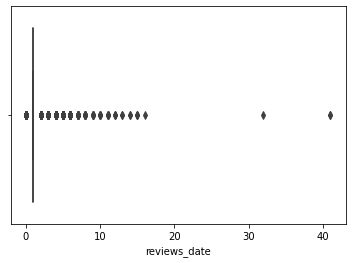

In [339]:
sns.boxplot(min_user_rating['reviews_date'])

In [340]:
min_user_rating[min_user_rating['reviews_date']>=3].shape

(602, 2)

In [361]:
ratings = ratings.rename(columns={'reviews_username':'userId', 'name':'movieId', 'reviews_rating':'rating'})

In [362]:
from sklearn.preprocessing import LabelEncoder

In [363]:
le_usr = LabelEncoder()
le_usr = le_usr.fit(ratings['userId'])
ratings['userId'] = le_usr.transform(ratings['userId'])

le_name = LabelEncoder()
le_name = le_name.fit(ratings['movieId'])
ratings['movieId'] = le_name.fit_transform(ratings['movieId'])
ratings.head()

,userId,movieId,rating,reviews_date
0,11440,182,5,2012-11-30T06:21:45.000Z
1,6974,140,5,2017-07-09T00:00:00.000Z
2,6974,140,5,2017-07-09T00:00:00.000Z
3,19327,120,1,2016-01-06T00:00:00.000Z
4,24205,120,1,2016-12-21T00:00:00.000Z


In [348]:
ratings[ratings['userId']==24909]

,userId,movieId,rating,reviews_date
9103,24909,65,5,2014-12-02T00:53:21.000Z
12732,24909,65,5,2014-12-02T00:00:00.000Z


In [364]:
le_usr.inverse_transform([24909])

array(['zxcsdfd'], dtype=object)

## User-User Based Recommendation

In [399]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=42)

In [400]:
train.shape, test.shape

((20955, 4), (8981, 4))

In [401]:
df_pivot = train.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

df_pivot.head(3)

movieId,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,268,269,270
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [402]:
dummy_train = train.copy()
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [403]:
dummy_train = dummy_train.pivot_table(
    index='userId',
    columns='movieId',
    values='rating').fillna(1)

In [404]:
dummy_train.head()

movieId,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,268,269,270
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [405]:
df_pivot.index.nunique()

18273

In [406]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [407]:
user_correlation.shape

(18273, 18273)

In [408]:
df_pivot = train.pivot_table(
    index='userId',
    columns='movieId',
    values='rating')

In [411]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)

In [412]:
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [413]:
user_correlation.shape

(18273, 18273)

## Evaluation: User-User

In [250]:
common = test[test.userId.isin(train.userId)]
common_user_based_matrix = common.pivot_table(index='userId', columns='movieId', values='rating')
user_correlation_df = pd.DataFrame(user_correlation)

In [251]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)

In [253]:
list_name = common.userId.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [254]:
user_correlation_df_3[user_correlation_df_3<0]=0
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))

In [255]:
dummy_test = common.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [256]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)
common_user_predicted_ratings.head()

movieId,0,1,9,10,14,15,16,17,19,20,...,253,254,255,256,257,258,260,263,264,268
userId,,,,,,,,,,,,,,,,,,,,,
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(feature_range=(1, 5))


In [259]:
common_ = common.pivot_table(index='userId', columns='movieId', values='rating')
total_non_nan = np.count_nonzero(~np.isnan(y))

In [260]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.534229490238383


## Prediction: User

In [393]:
df_pivot_w = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating').fillna(0)

In [394]:
user_correlation_w = 1 - pairwise_distances(df_pivot_w, metric='cosine')
user_correlation_w[np.isnan(user_correlation_w)] = 0
print(user_correlation_w)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [415]:
mean = np.nanmean(df_pivot_w, axis=1)
df_subtracted_w = (df_pivot_w.T-mean).T

user_correlation_df_w = pd.DataFrame(user_correlation_w)
user_correlation_df_w['userId'] = df_subtracted_w.index
user_correlation_df_w.set_index('userId', inplace=True)

In [262]:
user_correlation[user_correlation<0]=0

In [263]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)

In [390]:
# Take the user ID as input.
user_input = int(input("Enter your user name: "))
print(le_usr.inverse_transform([user_input]))

Enter your user name: 1
['00sab00']


In [391]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5].to_frame()
d = d.reset_index()
d.drop(d.columns[1], axis=1, inplace=True)
d

,movieId
0,93
1,183
2,239
3,65
4,200


In [392]:
movie_name = le_name.inverse_transform(d['movieId'])
d['movie_name'] = movie_name
d

,movieId,movie_name
0,93,Godzilla 3d Includes Digital Copy Ultraviolet ...
1,183,Planes: Fire Rescue (2 Discs) (includes Digita...
2,239,The Resident Evil Collection 5 Discs (blu-Ray)
3,65,Clorox Disinfecting Wipes Value Pack Scented 1...
4,200,Red (special Edition) (dvdvideo)
